# Autistic Face Reader (Part 2)

### 0: Import Libraries

In [1]:
# Basic libraries
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import seaborn as sns
import random
random.seed(20)
import os
import gc
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm #to create progress bar

# Magic command
%matplotlib inline

# Data pre-processing
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
#from tensorflow.keras.preprocessing.image import NumpyArrayIterator
from sklearn.model_selection import train_test_split

# Model building
from keras.models import Model
from tensorflow.keras import models, Sequential
from tensorflow.keras import optimizers, layers, applications
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import Flatten, Dense, Activation, BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Transfer learning
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam,RMSprop

# Model evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve


2023-02-07 17:07:55.728817: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print(os.listdir('./data'))

['valid', 'consolidated', '.DS_Store', 'test', 'train', '.ipynb_checkpoints']


### 1: Data Import

`1-1: Set parameters and labels`

In [3]:
FAST_RUN = False
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3 # 3 for Colored Images and 1 for Grayscale Images
BATCH_SIZE=20
EPOCHS= 20

if FAST_RUN:
    EPOCHS= 5 

In [4]:
class_names = ['non_autistic','autistic']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

In [5]:
class_names_label

{'non_autistic': 0, 'autistic': 1}

`1-2: Load images`

In [6]:
def load_data():

    train_datasets = ['./data/train', './data/valid']
    test_datasets = ['./data/test']
    
    output = []

    # Iterate through training sets
    images = []
    labels = []
        
    for dataset in train_datasets:

        print("Loading {}".format(dataset))

        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            if(folder=='autistic'):
                label=1
            else:
                label=0

            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                # Open and resize the img
                image = cv2.imread(img_path,cv2.IMREAD_COLOR)
                
                if image is None: # To account for broken images
                    continue
                #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)

    images = np.array(images)
    labels = np.array(labels)   

    output.append((images, labels))
    
    # Iterate through test sets
    for dataset in test_datasets:

        images = []
        labels = []

        print("Loading {}".format(dataset))

        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            if(folder=='autistic'):
                label=1
            else:
                label=0

            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                # Open and resize the img
                image = cv2.imread(img_path,cv2.IMREAD_COLOR)
                
                if image is None: # To account for broken images
                    continue
                #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)

        images = np.array(images)
        labels = np.array(labels)   

    output.append((images, labels))
    
    return output

In [7]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading ./data/train


100%|█████████████████████████████████████| 1266/1266 [00:01<00:00, 1057.84it/s]


Loading ./data/valid


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 942.93it/s]


Loading ./data/test


100%|███████████████████████████████████████| 150/150 [00:00<00:00, 1115.76it/s]


### 2: Data Pre-processing

`2-1: Shuffle training dataset` <br>
Shuffling the training dataset can help to improve the model's ability to generalise to different kinds of image data.

In [8]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=random.seed(20))

`2-2: Overview of train and test dataset`

In [9]:
print(train_labels.shape[0])
print(test_labels.shape[0])

2630
300


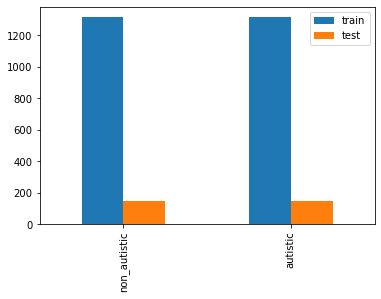

In [10]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

`2-3: Tweak data format`

In [11]:
# y_train
train_labels=to_categorical(train_labels,2)

# y_test
test_labels=to_categorical(test_labels,2)

In [12]:
# view y_train as array
train_labels[0:5]

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [13]:
# view shape of x_train
train_images.shape

(2630, 224, 224, 3)

### 3: Data Augmentation
`3-1: Data Augmentation for Train set` <br>
The training dataset underwent further data augmentation to help improve model's generalisationability.
Choosing a horizontal flip allows the model to learn about facial image data captured from different angles. Applying a 15 degree rotation further increases variability of the dataset.

In [14]:
train_datagen = ImageDataGenerator(
    rescale=1./255,          # normalize pixel values between 0-1
    rotation_range=15,       # random rotation by 15 degrees
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,    # 180 degree horizontal flip 
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator= train_datagen.flow(
    train_images, 
    train_labels,
    batch_size= BATCH_SIZE)

`3-2: Data Augmentation for Test set`

In [15]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator= test_datagen.flow(test_images, test_labels,batch_size= BATCH_SIZE)

`3-3: View sample of augmented images`

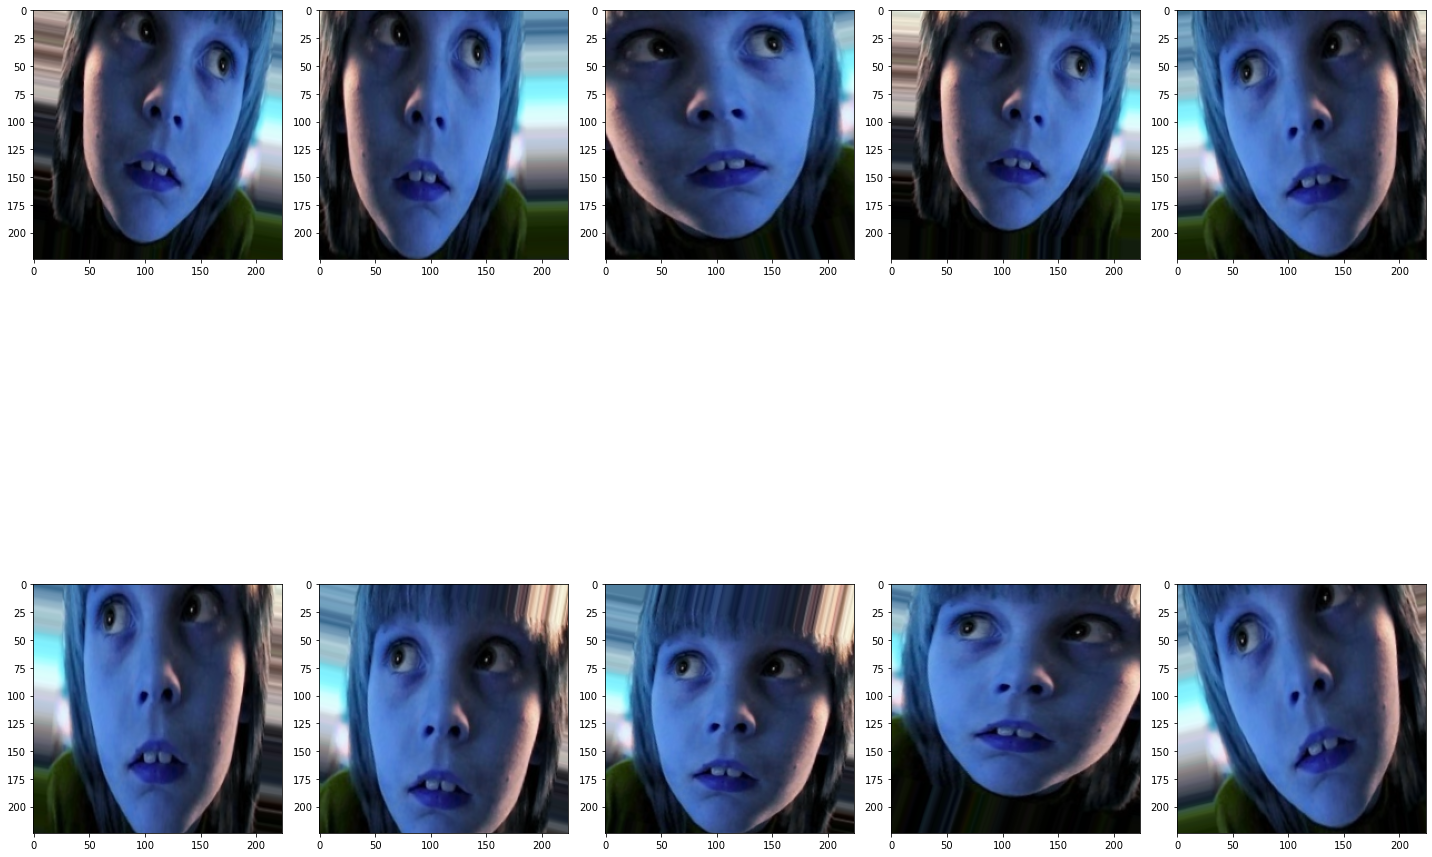

In [16]:
def plotImages(images_arr):
    fig, axes = plt.subplots(2, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
    

augmented_images = [train_generator[0][0][0] for i in range(10)]
plotImages(augmented_images)

### 4. Define Callbacks, etc

`4-1: Early Stopping` <br>
This stops the model training when a monitored metric has stopped improving.

In [17]:
earlystop = EarlyStopping(patience=10)

`4-2: Reduce Learning Rate` <br>
This decreases the learning rate when a metric has stopped improving.

In [18]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.1, 
                                            min_lr=0.00001)

In [19]:
callbacks = [earlystop, learning_rate_reduction]

`4-3: Define function to plot training curve`

In [20]:
def plot_training_curves(history,model_name):
    plt.figure(figsize=(16,8))
    
    plt.subplot(2,2,1)
    plt.plot(history.history['accuracy'], label='Train accuracy')
    plt.plot(history.history['val_accuracy'], label='Val accuracy')
    plt.legend()
    plt.title(f'{model_name} (Accuracy)', fontweight='bold', fontsize=10)
    
    plt.subplot(2,2,2)
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title(f'{model_name} (Loss)', fontweight='bold', fontsize=10);   

### 5: Model 1 - Custom CNN
`5-1: Instantiate model 1 (baseline)`

In [21]:
model1 = Sequential()
# Add convolutional layers
## 1st convolutional layer
model1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model1.add(MaxPooling2D(pool_size=(2, 2)))

## 2nd convolutional layer
model1.add(Conv2D(32, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

## 3rd convolutional layer
model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

## 4th convolutional layer
model1.add(Conv2D(64, (3,3), activation='relu')),
model1.add(MaxPooling2D(pool_size=(2,2)))

## 5th convolutional layer
model1.add(Conv2D(128, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

#Flatten results to fit into the fully connected dense layer
model1.add(Flatten())
model1.add(Dense(256, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(2, activation='softmax'))

#Compile the model
model1.compile(loss='binary_crossentropy', optimizer="rmsprop",metrics=['accuracy'])

#View summary of model built
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

2023-02-07 17:08:08.568748: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


`5-2: Train model 1 (baseline)`

In [22]:
%%time
history_1 = model1.fit(train_generator,
    epochs=EPOCHS,
    validation_data= test_generator,
    steps_per_epoch=train_images.shape[0]/BATCH_SIZE,
    callbacks=callbacks 
) 

Epoch 1/20
131/131 [==============================] - 54s 402ms/step - loss: 0.7009 - accuracy: 0.5038 - val_loss: 0.6861 - val_accuracy: 0.6933 - lr: 0.0010
Epoch 2/20
131/131 [==============================] - 59s 450ms/step - loss: 0.6704 - accuracy: 0.5985 - val_loss: 0.5547 - val_accuracy: 0.7167 - lr: 0.0010
Epoch 3/20
131/131 [==============================] - 9820s 75s/step - loss: 0.6098 - accuracy: 0.6802 - val_loss: 0.5779 - val_accuracy: 0.6900 - lr: 0.0010
Epoch 4/20
131/131 [==============================] - 73s 553ms/step - loss: 0.5962 - accuracy: 0.6958 - val_loss: 0.4760 - val_accuracy: 0.7900 - lr: 0.0010
Epoch 5/20
131/131 [==============================] - 72s 547ms/step - loss: 0.5691 - accuracy: 0.7148 - val_loss: 0.5168 - val_accuracy: 0.7467 - lr: 0.0010
Epoch 6/20
131/131 [==============================] - 74s 559ms/step - loss: 0.5439 - accuracy: 0.7350 - val_loss: 0.4779 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 7/20
131/131 [==============================] 

`5-3: Evaluate model 1 (baseline)`

In [23]:
test_loss = model1.evaluate(test_images, test_labels)

10/10 [==============================] - 3s 250ms/step - loss: 21.6763 - accuracy: 0.7600


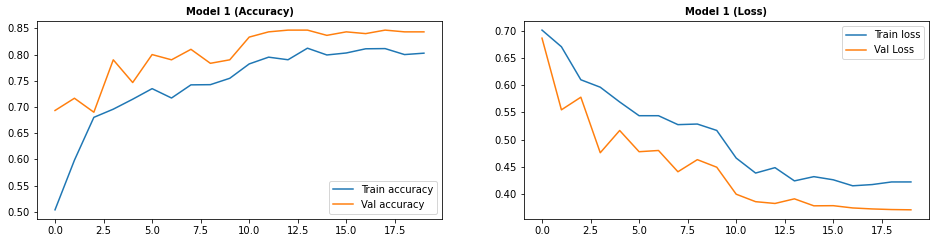

In [24]:
plot_training_curves(history_1,'Model 1')

### 8: Model 2
`8-1: Transfer Learning with VGG-16`

In [25]:
# load base model
 # pretrained convolutional layers are loaded using the Imagenet weights.
    # include_top is set to False, in order to exclude the model's fully-connected layers.
base_model = VGG16(
    weights="imagenet",
    include_top=False, 
    input_shape=IMAGE_SIZE+ (3,)
)

model2 = Sequential()
model2.add(base_model)
model2.add(Flatten())
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(2, activation='softmax'))

model2.layers[0].trainable = False

model2.compile(
    loss='binary_crossentropy',
    optimizer="rmsprop"(learning_rate=1e-4),
    metrics=['accuracy']
)

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_1 (Dropout)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 2)                 50178     
                                                                 
Total params: 14,764,866
Trainable params: 50,178
Non-trainable params: 14,714,688
_________________________________________________________________


`8-2: Train model 2`

In [26]:
%%time
history_2 = model2.fit(train_generator,
    epochs=EPOCHS,
    validation_data= test_generator,
    steps_per_epoch=train_images.shape[0]/BATCH_SIZE,
    callbacks=callbacks 
) 

Epoch 1/20
131/131 [==============================] - 461s 3s/step - loss: 0.6866 - accuracy: 0.6240 - val_loss: 0.5300 - val_accuracy: 0.7533 - lr: 1.0000e-04
Epoch 2/20
131/131 [==============================] - 425s 3s/step - loss: 0.6041 - accuracy: 0.6954 - val_loss: 0.4695 - val_accuracy: 0.7933 - lr: 1.0000e-04
Epoch 3/20
131/131 [==============================] - 395s 3s/step - loss: 0.5621 - accuracy: 0.7190 - val_loss: 0.4481 - val_accuracy: 0.8033 - lr: 1.0000e-04
Epoch 4/20
131/131 [==============================] - 544s 4s/step - loss: 0.5375 - accuracy: 0.7483 - val_loss: 0.4341 - val_accuracy: 0.8300 - lr: 1.0000e-04
Epoch 5/20
131/131 [==============================] - 2216s 17s/step - loss: 0.5117 - accuracy: 0.7616 - val_loss: 0.4153 - val_accuracy: 0.8300 - lr: 1.0000e-04
Epoch 6/20
131/131 [==============================] - 4186s 32s/step - loss: 0.5059 - accuracy: 0.7605 - val_loss: 0.4055 - val_accuracy: 0.8400 - lr: 1.0000e-04
Epoch 7/20
131/131 [================

`8-3 Evaluate model 2`

In [27]:
test_loss = model2.evaluate(test_images, test_labels)

10/10 [==============================] - 41s 4s/step - loss: 4.4015 - accuracy: 0.7600


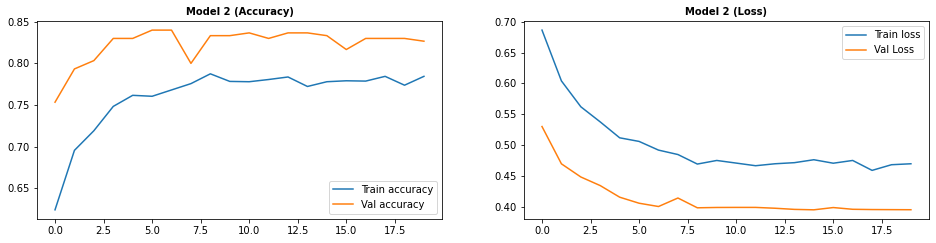

In [28]:
plot_training_curves(history_2,'Model 2')

`8-4 Save model 2`

In [29]:
model2.save('model2.h5')

#Load Model
#model2= keras.models.load_model(".data/model2.h5")

### 9. Make Predictions

In [30]:
predictions = model2.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

10/10 [==============================] - 83s 8s/step


In [31]:
#Reverse conversion from to_categorical
test_labels_vector = np.argmax(test_labels, axis = 1)

### 10. Results

`Confusion Matrix`

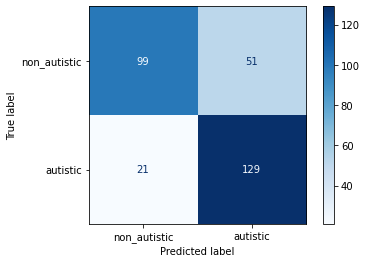

In [32]:
cm = confusion_matrix(test_labels_vector, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

`Classification Report`

In [33]:
from sklearn.metrics import classification_report
print(classification_report(test_labels_vector, pred_labels, target_names = class_names))

              precision    recall  f1-score   support

non_autistic       0.82      0.66      0.73       150
    autistic       0.72      0.86      0.78       150

    accuracy                           0.76       300
   macro avg       0.77      0.76      0.76       300
weighted avg       0.77      0.76      0.76       300



`View samples of classified images`

In [34]:
def classification_evaluation(classification, predicted_labels, test_labels, test_images):
    if classification== "correct":
        indices_list = np.where(predicted_labels == test_labels)[0]
    else:
        indices_list = np.where(predicted_labels!= test_labels)[0]
    
    test_images_filtered= [test_images[i] for i in indices_list]
    images_labels_original= [test_labels[i] for i in indices_list]
    images_labels_predicted= [pred_labels[i] for i in indices_list]
    print(f"{len(test_images_filtered)} images were classified {classification.upper()} out of a total of {len(test_images)} in the Test dataset")

    unique, counts = np.unique(images_labels_original, return_counts=True)
    for i in range(0,len(unique)):
        print(f"for category {unique[i]} the number of {classification.upper()} classified images were: {counts[i]}")
        
    # Plot some of the misclassified images
    print("\n\n")
    fig,ax=plt.subplots(5,2)
    fig.suptitle(f"Sample of {classification.upper()} Classified Images", fontsize=20)
    fig.set_size_inches(15,15)
    for i in range(5):
        for j in range (2):
            l=random.randint(0,len(test_images_filtered))
            ax[i,j].imshow(test_images_filtered[l])
            ax[i,j].set_title("Predicted: "+str(images_labels_predicted[l])+"\n"+"Actual: "+str(images_labels_original[l]))
    plt.tight_layout()

228 images were classified CORRECT out of a total of 300 in the Test dataset
for category 0 the number of CORRECT classified images were: 99
for category 1 the number of CORRECT classified images were: 129





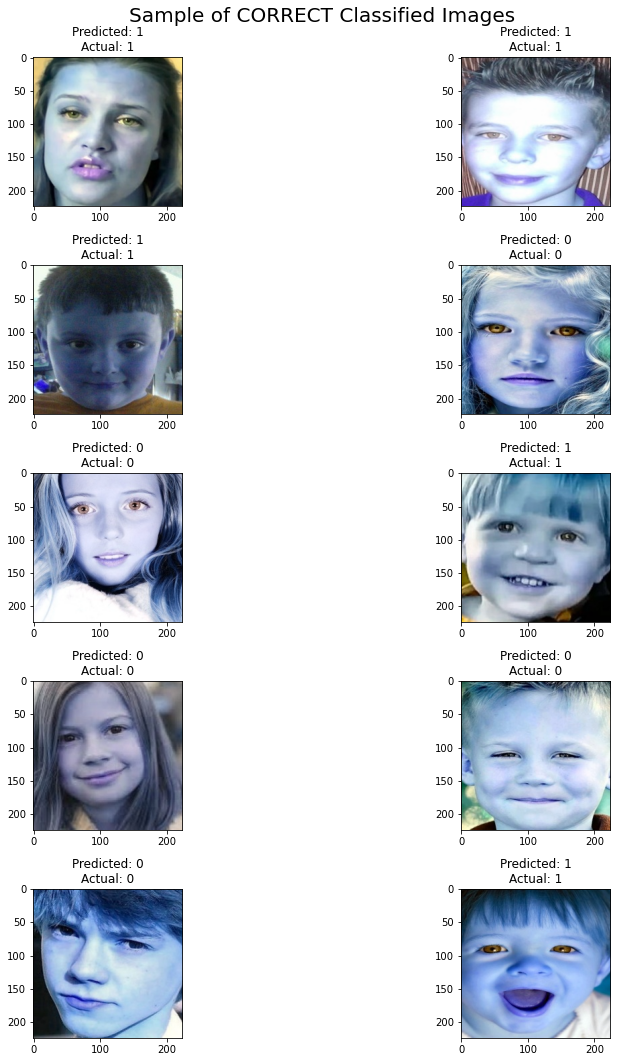

In [35]:
classification_evaluation("correct", pred_labels, test_labels_vector, test_images)

72 images were classified WRONG out of a total of 300 in the Test dataset
for category 0 the number of WRONG classified images were: 51
for category 1 the number of WRONG classified images were: 21





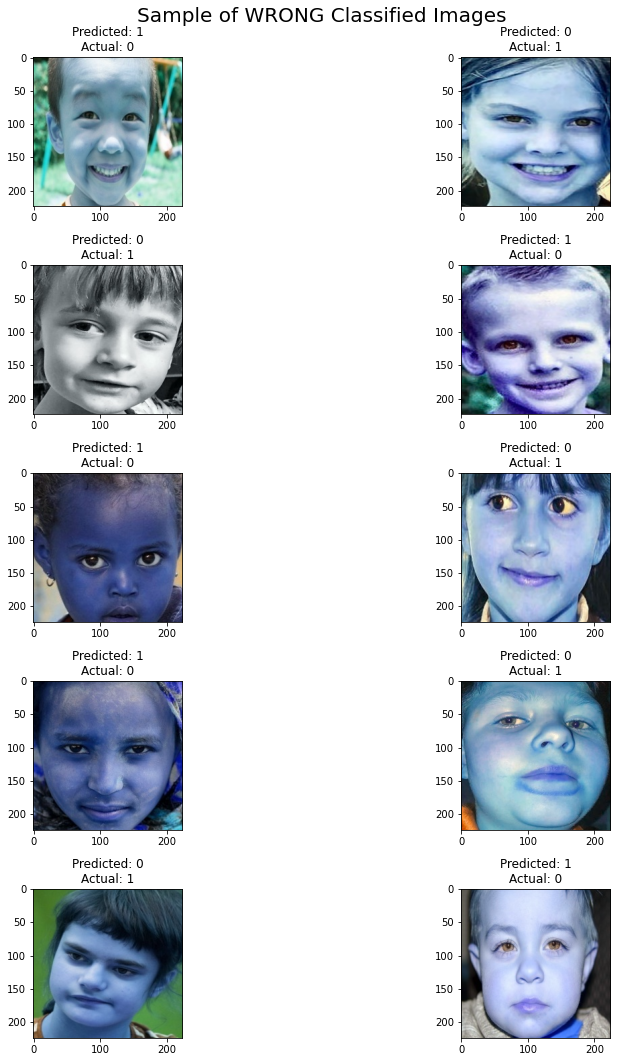

In [36]:
classification_evaluation("wrong", pred_labels, test_labels_vector, test_images)